In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/shanghaitech


In [ ]:
!pip install scipy opencv-python-headless

import numpy as np
import tensorflow as tf
import cv2
import os
import scipy.io as sio
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models


In [ ]:
# ---------- Dataset Loader ----------
class ShanghaiTechDataset(Sequence):
    def __init__(self, image_dir, gt_dir, batch_size=4, img_size=(256, 256)):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.gt_paths = [
            os.path.join(gt_dir, 'GT_' + os.path.basename(f).replace('.jpg', '.mat'))
            for f in self.image_paths
        ]
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.gt_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        imgs, dens = [], []
        for img_path, mat_path in zip(batch_x, batch_y):
            img = load_img(img_path)
            img = img.resize(self.img_size)
            img = img_to_array(img) / 255.0

            dmap = get_density_map_from_mat(mat_path, img.shape[:2])
            dmap = cv2.resize(dmap, self.img_size)
            dmap = np.expand_dims(dmap, axis=-1)

            imgs.append(img)
            dens.append(dmap)

        return np.array(imgs), np.array(dens)

# ---------- Density Map Helper ----------
def get_density_map_from_mat(mat_path, shape, sigma=15):
    mat = sio.loadmat(mat_path)
    points = mat['image_info'][0][0][0][0][0]  # (N, 2)
    density_map = np.zeros(shape, dtype=np.float32)
    for point in points:
        x = min(int(point[0]), shape[1] - 1)
        y = min(int(point[1]), shape[0] - 1)
        density_map[y, x] = 1
    density_map = cv2.GaussianBlur(density_map, (0, 0), sigma)
    return density_map

# ---------- U-Net Model ----------
def build_unet(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D()(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    output = layers.Conv2D(1, 1, activation=None)(c5)

    return tf.keras.Model(inputs, output)

In [ ]:
train_dataset = ShanghaiTechDataset(
    image_dir='/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images',
    gt_dir='/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth',
    batch_size=32
)

val_dataset = ShanghaiTechDataset(
    image_dir='/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images',
    gt_dir='/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth',
    batch_size=32
)
def count_loss(y_true, y_pred):
    density_loss = tf.keras.losses.MSE(y_true, y_pred)
    count_true = tf.reduce_sum(y_true, axis=[1, 2, 3])
    count_pred = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    count_loss = tf.keras.losses.MSE(count_true, count_pred)
    return density_loss + 0.001 * count_loss

model = build_unet()
model.compile(optimizer='adam', loss=count_loss, metrics=['mae'])

model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 123181.0781 - mae: 0.0867 - val_loss: 146.0797 - val_mae: 0.0060
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 84.7932 - mae: 0.0050 - val_loss: 23.9614 - val_mae: 0.0037
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 35.9801 - mae: 0.0039 - val_loss: 40.7763 - val_mae: 0.0041
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 33.5806 - mae: 0.0037 - val_loss: 23.9274 - val_mae: 0.0033
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 23.8833 - mae: 0.0033 - val_loss: 21.6585 - val_mae: 0.0032
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 23.8672 - mae: 0.0032 - val_loss: 21.4887 - val_mae: 0.0032
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 19.9304 - mae: 0.0031 - val_loss: 24.3503 - val_mae: 0.0031
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 21.1070 - mae: 0.0030 - val_loss: 20.1414 - val_mae: 0.0031
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


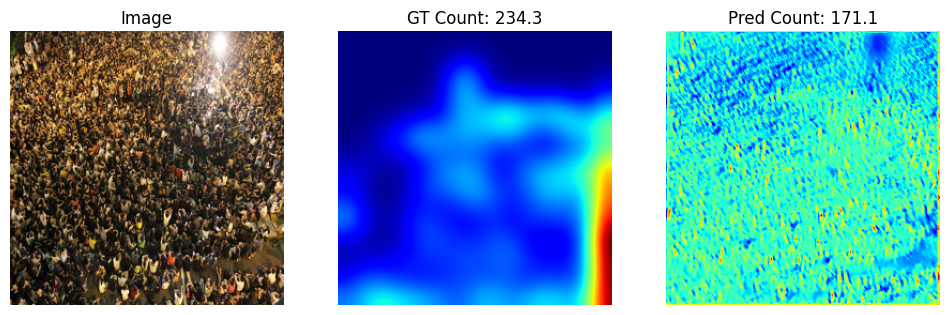

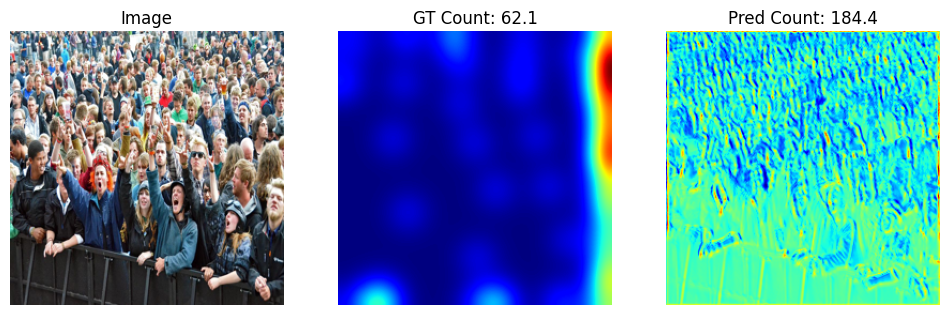

In [ ]:
import matplotlib.pyplot as plt

imgs, gt_dmaps = val_dataset[0]
pred_dmaps = model.predict(imgs)

for i in range(6,8):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_dmaps[i].squeeze(), cmap='jet')
    plt.title(f"GT Count: {np.sum(gt_dmaps[i]):.1f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_dmaps[i].squeeze(), cmap='jet')
    plt.title(f"Pred Count: {np.sum(pred_dmaps[i]):.1f}")
    plt.axis('off')

    plt.show()


In [ ]:
# ---------------- MCNN Model ----------------
def build_mcnn(input_shape=(256, 256, 3)):
    def mcnn_branch(filters, kernel):
        model = tf.keras.Sequential([
            layers.Conv2D(filters, kernel, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(filters, kernel, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(filters, kernel, padding='same', activation='relu')
        ])
        return model

    inputs = tf.keras.Input(shape=input_shape)
    branch1 = mcnn_branch(16, 9)(inputs)
    branch2 = mcnn_branch(20, 7)(inputs)
    branch3 = mcnn_branch(24, 5)(inputs)

    merge = layers.concatenate([branch1, branch2, branch3])
    output = layers.Conv2D(1, 1, padding='same')(merge)
    output = layers.Lambda(lambda x: tf.image.resize(x, size=(256, 256), method='bilinear'))(output)

    return models.Model(inputs, output)

In [ ]:
model = build_mcnn()
model.compile(optimizer='adam', loss=count_loss)
model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 615623.8750 - val_loss: 15706.3350
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 866ms/step - loss: 6831.1768 - val_loss: 31.8794
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 787ms/step - loss: 744.4405 - val_loss: 480.7950
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 793ms/step - loss: 246.1500 - val_loss: 281.7262
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 927ms/step - loss: 176.1768 - val_loss: 107.6093
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 101.1377 - val_loss: 25.3703
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 741ms/step - loss: 42.5865 - val_loss: 24.0887
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - loss: 35.8276 - val_loss: 26.0497
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 875ms/step - loss: 36.8651 - val_loss: 23.2154
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 749ms/step - loss: 28.5790 - val_loss: 22.5309
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - loss: 31.0965 - val_loss: 22.1108
Epoch 12/20
10/10 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


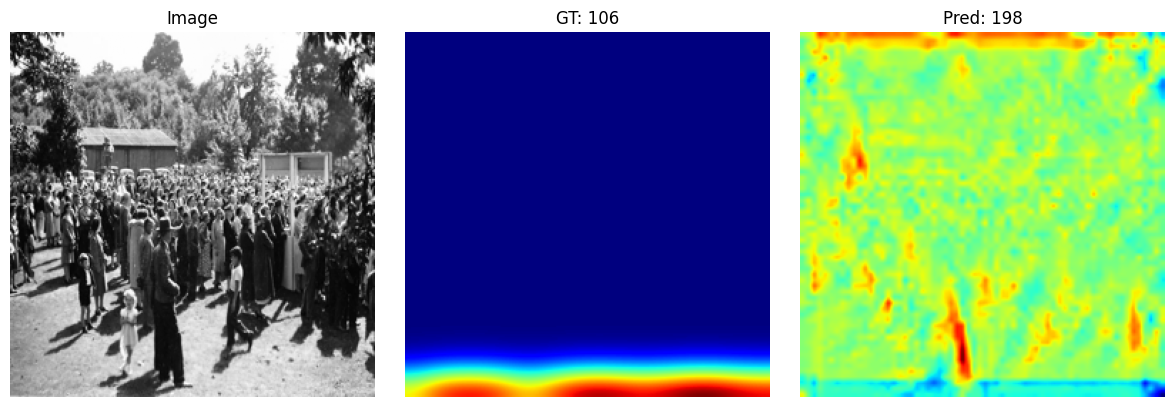

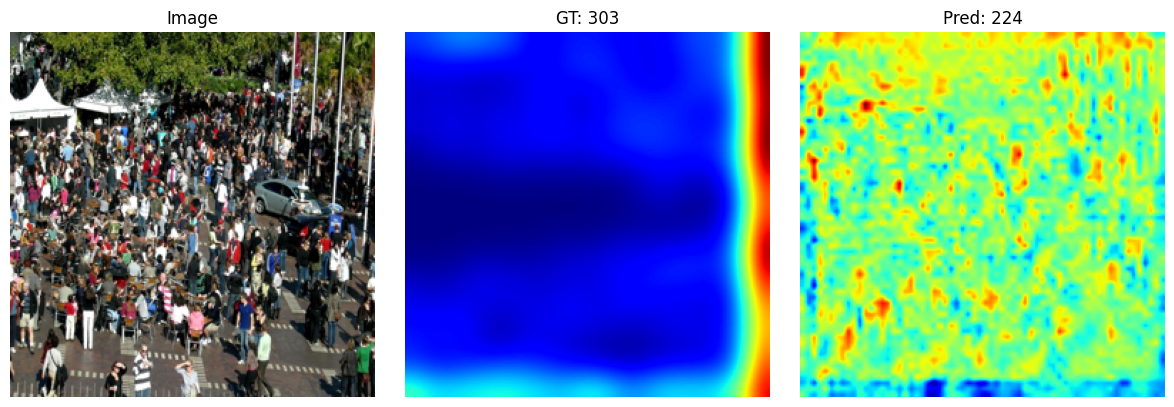

In [ ]:
def visualize(model, dataset, n=2):
    imgs, gt_dmaps = dataset[0]
    pred_dmaps = model.predict(imgs)

    for i in range(n):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(imgs[i])
        axs[0].set_title("Image")
        axs[0].axis('off')

        axs[1].imshow(gt_dmaps[i].squeeze(), cmap='jet')
        axs[1].set_title(f"GT: {np.sum(gt_dmaps[i]):.0f}")
        axs[1].axis('off')

        axs[2].imshow(pred_dmaps[i].squeeze(), cmap='jet')
        axs[2].set_title(f"Pred: {np.sum(pred_dmaps[i]):.0f}")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

visualize(model, val_dataset)